## Very good paper about omics dimensionality reduction 
https://academic.oup.com/bib/article/17/4/628/2240645

In [126]:
import time
from collections import defaultdict
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    explained_variance_score,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [224]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
lipid_superclasses = ['Phospholipid', 'Glycerolipid', 'Sphingolipid', 'Fatty Acyl', 'Sterol Lipid', 'Unidentified']
    
    
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns

In [225]:
# X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

X_all = data[data_cols].T

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

# PLS Regression is supervised regression. PLS-DA is the extension into classification

## Good examples
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_compare_cross_decomposition.html#sphx-glr-auto-examples-cross-decomposition-plot-compare-cross-decomposition-py

# In general, you do not need to center or standardize X for multiple regression: 
https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia

## The results from PCA and CCA are identical regardless of StandardScale or not


In [227]:
plsr = PLSRegression(n_components=2, max_iter=1000).fit(X_all, y_ogtt)
plsr.x_scores_[:, 0]
plsr

PLSRegression(max_iter=1000)

In [228]:
def pls_reg(subset):
    plsr = PLSRegression(n_components=2, max_iter=1000).fit(X_all.loc[subset], y_ogtt.loc[subset])
    scores = pd.DataFrame(plsr.x_scores_, index=y_ogtt.loc[subset].index, columns=['scores1', 'scores2'])
    scores = scores.join(fg['gluc_tol'])
    df = pd.DataFrame(plsr.x_loadings_, index=data.index, columns=['loadings1', 'loadings2'])
#     df['scores1'] = plsr.x_scores_[:, 0]
#     df['scores2'] = plsr.x_scores_[:, 1]
    df['coef'] = plsr.coef_
    df = df.join(data[data.columns[0:11].to_list() + ['molec_class']])
    df = df.loc[(df['Type'] == 'lipid')]
#     display(df)
    df['superclass'] = df['molec_class'].apply(lambda x: colors[x]['superclass'], )
    return df, scores

d = {}
for subset, name in zip([data_cols, rbg_cols, fbg_cols], ['all', 'rbg', 'fbg']):   
    d[name], d[name + '_scores'] = pls_reg(subset)

## Plot coefficients from PLSR, colored by lipid superclass

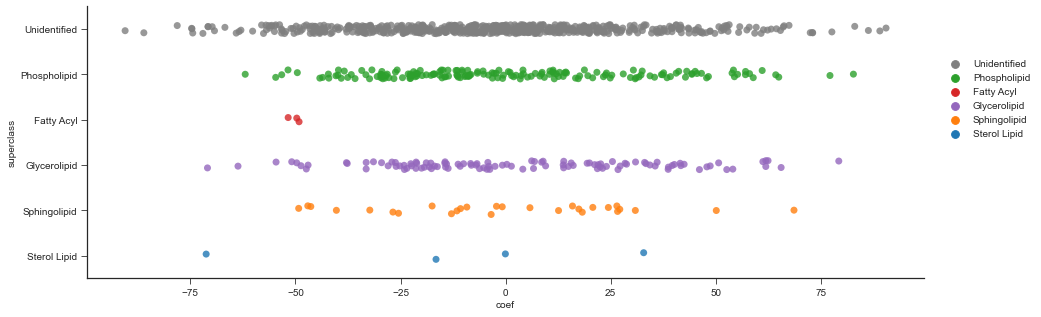

In [246]:
df = d['fbg'][['coef', 'superclass']].copy()
df['dummy'] = 0
df
fig, ax = plt.subplots(figsize=(15, 5))
sns.stripplot(
    data=df, x='coef', y='superclass', 
    orient='h', 
    s=7,
#     dodge=False,
    hue='superclass', palette=colors,
#     order=lipid_superclasses,
    alpha=0.8
)
plt.legend(loc=(1.02, 0.5))
sns.despine()

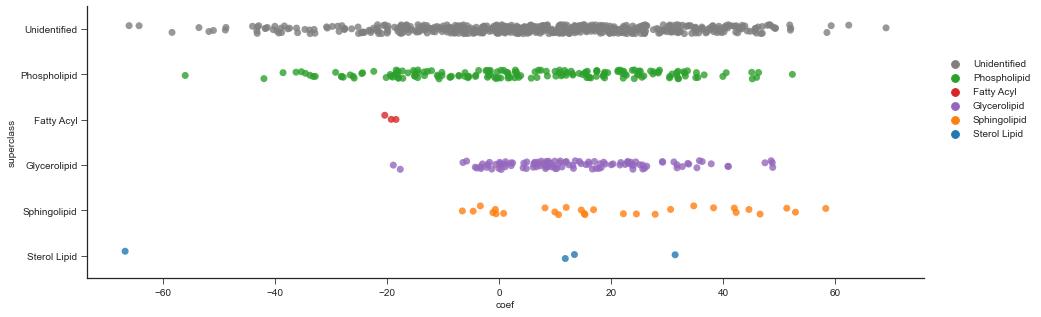

In [247]:
df = d['rbg'][['coef', 'superclass']].copy()
df['dummy'] = 0
df
fig, ax = plt.subplots(figsize=(15, 5))
sns.stripplot(
    data=df, x='coef', y='superclass', 
    orient='h', 
    s=7,
#     dodge=False,
    hue='superclass', palette=colors,
#     order=lipid_superclasses,
    alpha=0.8
)
plt.legend(loc=(1.02, 0.5))
sns.despine()

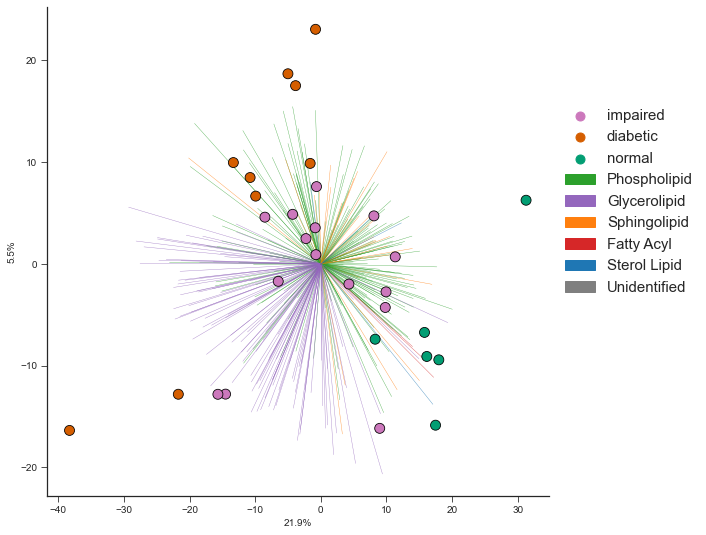

In [231]:
def make_biplot(subset, subset_cols):
    fig, ax = plt.subplots(figsize=(9, 9))
    for i, (index, row) in enumerate(d[subset].iterrows()):
        if row['ID'] == 'unknown':
            continue
        l1 = row['loadings1'] * 500
        l2 = row['loadings2'] * 350
        c = colors[row['superclass']]
        ax.arrow(0, 0, l1, l2, color=c, linewidth=0.4, alpha=0.4)
    scores = d[subset + '_scores']
    sns.scatterplot(
        data=scores, x='scores1', y='scores2',
        hue='gluc_tol', palette=colors,
        s=100, ax=ax, edgecolor='black')
    
    # https://stackoverflow.com/questions/46327928/sklearn-plsregression-variance-of-x-explained-by-latent-vectors
    total_X_var = np.var(X_all.loc[subset_cols], axis=0).sum()
    component_var = np.var(plsr.x_scores_, axis=0) / total_X_var
    plt.xlabel(f'{round(component_var[0]*100, 1)}%')
    plt.ylabel(f'{round(component_var[1]*100, 1)}%')
    
    # Make a few invisible dummy arrows to generate a legend
    
    for lsc in lipid_superclasses:
        ax.arrow(0, 0, 0, 0, color=colors[lsc], label=lsc)
    plt.legend(loc=(1.02, 0.4), markerscale=1.5, fontsize=15)
    sns.despine()
make_biplot('fbg', fbg_cols)

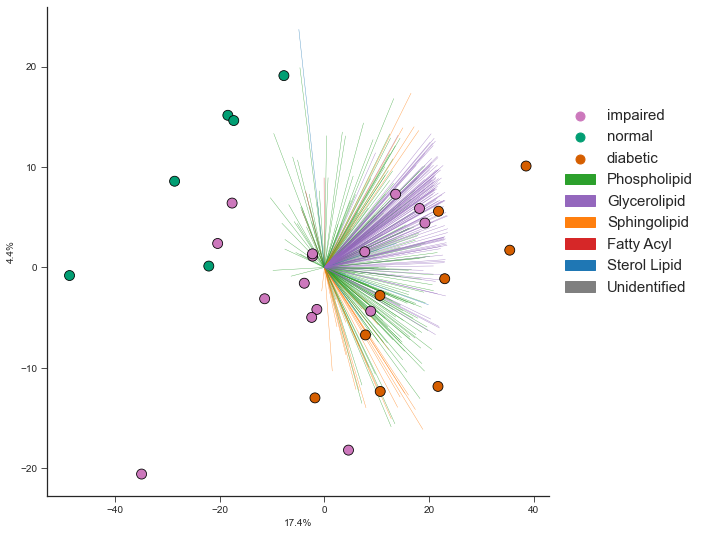

In [232]:
make_biplot('rbg', rbg_cols)

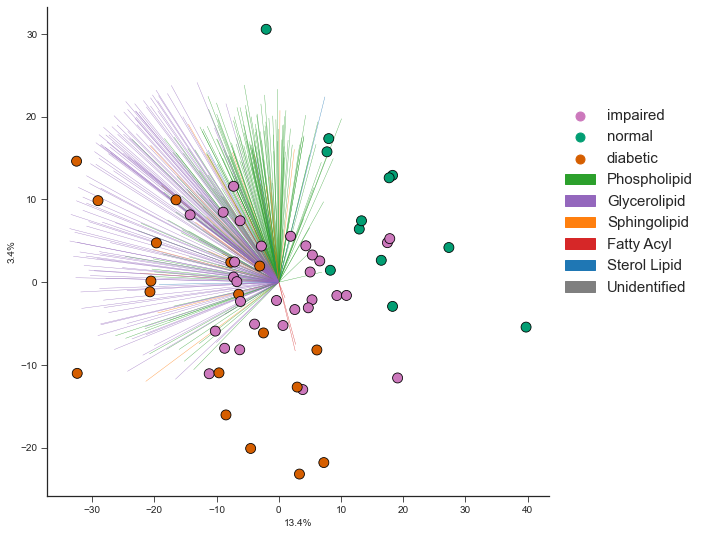

In [233]:
make_biplot('all', data_cols)

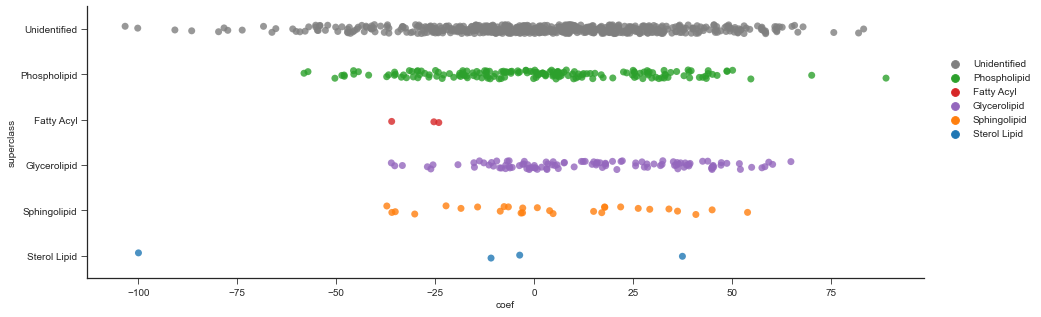

In [248]:
df = d['all'][['coef', 'superclass']].copy()
df['dummy'] = 0
df
fig, ax = plt.subplots(figsize=(15, 5))
sns.stripplot(
    data=df, x='coef', y='superclass', 
    orient='h', 
    s=7,
#     dodge=False,
    hue='superclass', palette=colors,
#     order=lipid_superclasses,
    alpha=0.8
)
plt.legend(loc=(1.02, 0.5))
sns.despine()

C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='0'>

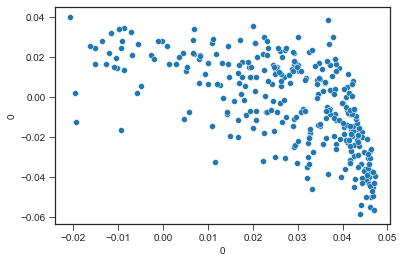

In [25]:
sns.scatterplot(d['rbg'][0], d['fbg'][0])

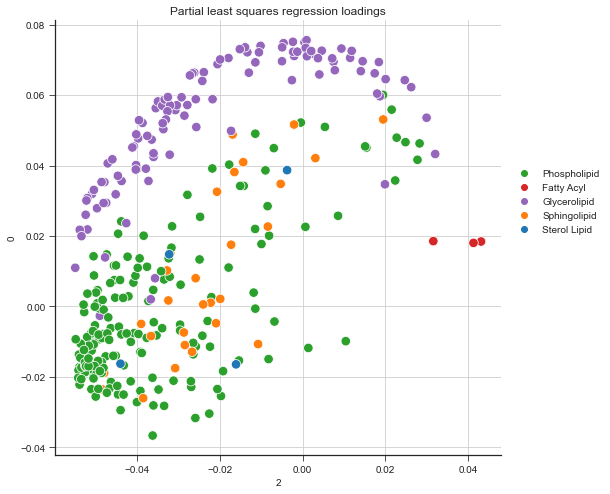

In [88]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Partial least squares regression loadings')

sns.scatterplot(
    data=df, x=2, y=0, hue='superclass',
    s=90, 
    palette=colors
)
plt.grid()
plt.legend(loc=(1.02, 0.5))
sns.despine()

In [138]:
ld = {}  # ld = LeaveOneGroupOut Dictionary

for columns, column_name in zip([rbg_cols, fbg_cols], ['RBG', 'FBG']):
    X = X_all.loc[columns]
    ld[column_name] = {}
    for y_data, y_name in (
        [y_ogtt, 'ogtt'], 
#         [y_weight, 'weight'], 
#         [y_insulin, 'insulin']
    ):
        y = y_data.loc[columns]
        ld[column_name][y_name] = {}
        
        for est, model_name in [(PLSRegression(n_components=1), 'pls'), (CCA(n_components=1), 'cca')]:
            d = ld[column_name][y_name][model_name] = {}
            d['feat_imp'] = 0
            d['y_true'] = []
            d['y_pred'] = []
            logo = LeaveOneGroupOut()
            for train, test in logo.split(X, y, groups=X.index.map(fg['animal'])):
                model = est.fit(X.iloc[train], y.iloc[train])
                y_pred = model.predict(X.iloc[test])
                d['feat_imp'] += model.coef_
                d['y_true'].extend(y.iloc[test])
                d['y_pred'].extend([val[0] for val in y_pred])

In [139]:
rp = ld['RBG']['ogtt']['pls']
fp = ld['FBG']['ogtt']['pls']
rc = ld['RBG']['ogtt']['cca']
fc = ld['FBG']['ogtt']['cca']

Text(0.5, 1.0, 'Fasted PLS\nMean absolute percentage error: 20.0%')

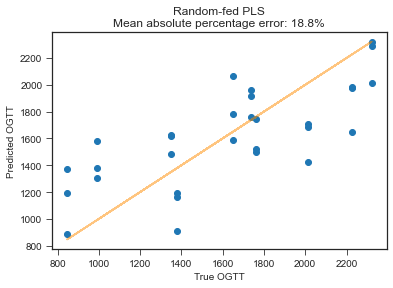

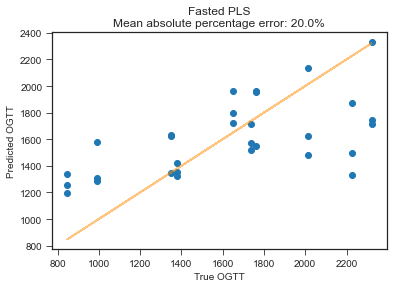

In [156]:
df = rp
y_true = np.array(df['y_true'])
y_pred = np.array(df['y_pred'])
resid = y_true - y_pred
plt.scatter(y_true, y_pred)
plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
plt.xlabel('True OGTT')
plt.ylabel('Predicted OGTT')
mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

plt.figure()

df = fp
y_true = np.array(df['y_true'])
y_pred = np.array(df['y_pred'])
resid = y_true - y_pred
plt.scatter(y_true, y_pred)
plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
plt.xlabel('True OGTT')
plt.ylabel('Predicted OGTT')
mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
plt.title(f'Fasted PLS\nMean absolute percentage error: {mean_perc_error}%')

In [151]:
plscoef = pd.DataFrame({'RBGpls': rp['feat_imp'][:, 0], 'FBGpls': fp['feat_imp'][:, 0],})
plscoef

# plscoef.to_csv(r'..\models\feat_importances\pls_regression_feature_importances.csv')

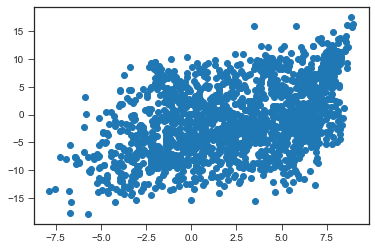

In [150]:
plt.scatter(plscoef['RBGpls'], plscoef['FBGpls'])

Text(0.5, 1.0, 'Distribution of coefficients for PLS Regression')

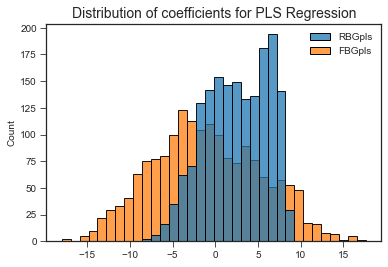

In [152]:
sns.histplot(plscoef)
plt.title('Distribution of coefficients for PLS Regression', fontsize=14)

### CCA is terrible. It predicts -7000 for some OGTT values

# regular CCA is limited to n > p, and does not do feature selection
### but other CCAs (sparse CCA, penalized CCA) can do feature selection 
https://academic.oup.com/bib/article/17/4/628/2240645


In [159]:
# df = rc
# y_true = np.array(df['y_true'])
# y_pred = np.array(df['y_pred'])
# resid = y_true - y_pred
# plt.scatter(y_true, y_pred)
# plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
# plt.xlabel('True OGTT')
# plt.ylabel('Predicted OGTT')
# mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
# plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

# plt.figure()

# df = fc
# y_true = np.array(df['y_true'])
# y_pred = np.array(df['y_pred'])
# resid = y_true - y_pred
# plt.scatter(y_true, y_pred)
# plt.plot(y_ogtt.loc[rbg_cols], y_ogtt.loc[rbg_cols], c='darkorange', alpha=0.5)
# plt.xlabel('True OGTT')
# plt.ylabel('Predicted OGTT')
# mean_perc_error = round(abs(resid / y_true).mean(), 3) * 100
# plt.title(f'Random-fed PLS\nMean absolute percentage error: {mean_perc_error}%')

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_ogtt, test_size=0.1, random_state=1)

pls = PLSRegression(n_components=20).fit(X_all.loc[rbg_cols], y_ogtt.loc[rbg_cols])
cca = CCA(n_components=1).fit(X_all.loc[rbg_cols], y_ogtt.loc[rbg_cols])

pls.coef_
cca.coef_

array([[ 13.32249139],
       [ 10.49394781],
       [  2.23460843],
       ...,
       [-13.58078583],
       [ -9.78616076],
       [-23.33105822]])

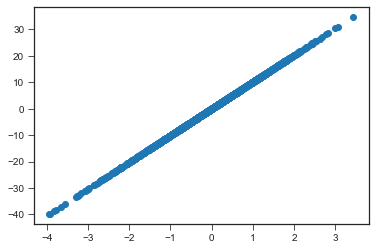

In [131]:
plt.scatter(pls.coef_, cca.coef_)

In [132]:
coefs = pd.DataFrame({'pls': pls.coef_[:, 0], 'cca': cca.coef_[:, 0]}, index=data.index)
display(coefs)
# coefs.to_csv(r'..\data\processed\PLS_CCA_coefficients.csv')

,pls,cca
i,,
l_0,1.315299,13.322491
l_1,1.036044,10.493948
l_2,0.220618,2.234608
l_3,-0.134158,-1.358870
l_4,0.087439,0.885663
...,...,...
m_169,-3.568107,-36.140882
m_213,-0.833284,-8.440222
m_24,-1.340800,-13.580786


In [107]:
pls.x_scores_.shape

(60, 20)

In [110]:
pls.predict(X_all)

array([[ 846.79139076],
       [ 846.72870009],
       [ 846.74373474],
       [ 993.0152532 ],
       [ 993.04815883],
       [ 993.07237432],
       [1761.77988734],
       [1761.69851686],
       [1761.67774109],
       [1648.81918916],
       [1648.80535111],
       [1648.72076514],
       [1350.245693  ],
       [1350.35066283],
       [1350.25858552],
       [1377.90803438],
       [1377.89210031],
       [1377.96677398],
       [1738.28566472],
       [1738.15436426],
       [1738.31602583],
       [2321.26275925],
       [2321.21605182],
       [2321.29861271],
       [2224.78612225],
       [2224.67184857],
       [2224.81803689],
       [2015.75279199],
       [2015.74926373],
       [2015.62653605],
       [ 846.70030477],
       [ 846.76229902],
       [ 846.79476615],
       [ 992.95633743],
       [ 992.99434746],
       [ 992.87615894],
       [1761.62317534],
       [1761.78557729],
       [1761.78027674],
       [1648.74512679],
       [1648.66008077],
       [1648.784

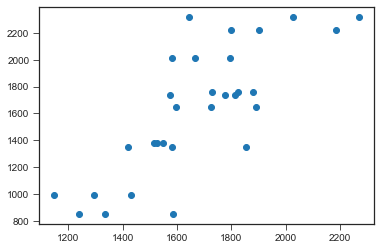

In [135]:
plt.scatter(pls.predict(X_all.loc[fbg_cols]), y_ogtt.loc[fbg_cols])
# plt.gcf().set_size_inches(10, 4)

In [73]:
pls.x_weights_.shape

(1727, 10)

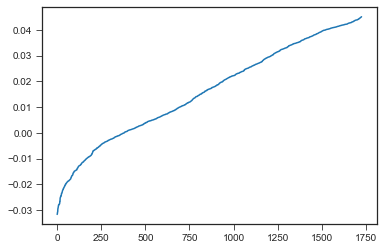

In [136]:
plt.plot(range(1727), np.sort(pls.x_loadings_[:, 0]))

In [95]:
pls.y_scores_.shape

(60, 10)

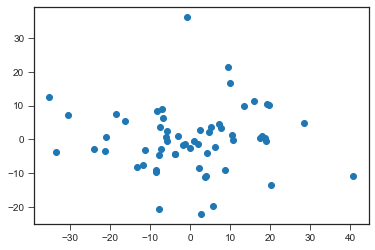

In [93]:
plt.scatter(pls.x_scores_[:, 0], pls.x_scores_[:, 1])

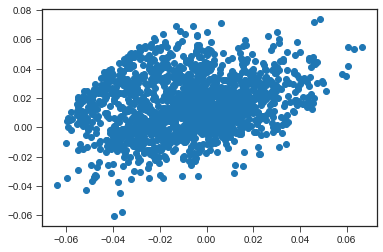

In [109]:
plt.scatter(pls.x_weights_[:, 0], pls.x_weights_[:, 1])

In [130]:
import numpy as np
import pylab as pl
from sklearn.decomposition import PLSCanonical, PLSRegression, CCA

###############################################################################
# Dataset based latent variables model

n = 500
# 2 latents vars:
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l1, l2, l2]).T
X = latents + np.random.normal(size=4 * n).reshape((n, 4))
Y = latents + np.random.normal(size=4 * n).reshape((n, 4))

X_train = X[:n / 2]
Y_train = Y[:n / 2]
X_test = X[n / 2:]
Y_test = Y[n / 2:]

print("Corr(X)")
print(np.round(np.corrcoef(X.T), 2))
print("Corr(Y)")
print(np.round(np.corrcoef(Y.T), 2))

###############################################################################
# Canonical (symetric) PLS

# Transform data
# ~~~~~~~~~~~~~~
plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
pl.figure(figsize=(12, 8))
pl.subplot(221)
pl.plot(X_train_r[:, 0], Y_train_r[:, 0], "ob", label="train")
pl.plot(X_test_r[:, 0], Y_test_r[:, 0], "or", label="test")
pl.xlabel("x scores")
pl.ylabel("y scores")
pl.title('Comp. 1: X vs Y (test corr = %.2f)' %
         np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
pl.xticks(())
pl.yticks(())
pl.legend(loc="best")

pl.subplot(224)
pl.plot(X_train_r[:, 1], Y_train_r[:, 1], "ob", label="train")
pl.plot(X_test_r[:, 1], Y_test_r[:, 1], "or", label="test")
pl.xlabel("x scores")
pl.ylabel("y scores")
pl.title('Comp. 2: X vs Y (test corr = %.2f)' %
         np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
pl.xticks(())
pl.yticks(())
pl.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
pl.subplot(222)
pl.plot(X_train_r[:, 0], X_train_r[:, 1], "*b", label="train")
pl.plot(X_test_r[:, 0], X_test_r[:, 1], "*r", label="test")
pl.xlabel("X comp. 1")
pl.ylabel("X comp. 2")
pl.title('X comp. 1 vs X comp. 2 (test corr = %.2f)' % \
    np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
pl.legend(loc="best")
pl.xticks(())
pl.yticks(())

pl.subplot(223)
pl.plot(Y_train_r[:, 0], Y_train_r[:, 1], "*b", label="train")
pl.plot(Y_test_r[:, 0], Y_test_r[:, 1], "*r", label="test")
pl.xlabel("Y comp. 1")
pl.ylabel("Y comp. 2")
pl.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)' % \
    np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
pl.legend(loc="best")
pl.xticks(())
pl.yticks(())
pl.show()

###############################################################################
# PLS regression, with multivariate response, a.k.a. PLS2

n = 1000
q = 3
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
B = np.array([[1, 2] + [0] * (p - 2)] * q).T
# each Yj = 1*X1 + 2*X2 + noize
Y = np.dot(X, B) + np.random.normal(size=n * q).reshape((n, q)) + 5

pls2 = PLSRegression(n_components=3)
pls2.fit(X, Y)
print("True B (such that: Y = XB + Err)")
print(B)
# compare pls2.coefs with B
print("Estimated B")
print(np.round(pls2.coefs, 1))
pls2.predict(X)

###############################################################################
# PLS regression, with univariate response, a.k.a. PLS1

n = 1000
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(size=n * 1) + 5
pls1 = PLSRegression(n_components=3)
pls1.fit(X, y)
# note that the number of compements exceeds 1 (the dimension of y)
print("Estimated betas")
print(np.round(pls1.coefs, 1))

###############################################################################
# CCA (PLS mode B with symetric deflation)

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

ImportError: cannot import name 'PLSCanonical' from 'sklearn.decomposition' (C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\decomposition\__init__.py)